# Predicting Sales - 1C Software

## Overview

In this competition you will work with a challenging **time-series dataset** consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict **total sales for every product and store in the next month**. By solving this competition you will be able to apply and enhance your data science skills.

## Submission

Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

### From the data scientist...

This is my working notebook demonstrating the cleaning, processing, and feature engineering of a real-world dataset used to predict future sales. I learned a good deal about time-series data (and this specific data set), to wit:

1. Time-series data is inherently unsupervised. We can choose what we'd like to predict, and with the some descriptive data to add variance and engineering of lag features, we can utilize supervised learning methods. Since there are many shop/item_id combinations in this dataset, and historical data to train on, we naturally have a 'big data' problem to which we must consider when using which algorithms and methods of cross-validation.
2. The importance of feature engineering, specifically 'lag' features. Feature engineering is a common task in machine learning, as the goal is to decrease the complexity of the data through manual effort (effort derived from domain knowledge and a lot of visualization/savvy techniques). We want to decrease complexity to aid the algorithm in discovering patterns more easily (and in less time). Lag features are essentially shifted 'windows' (or 'sliding window') of data - it's not new data, just transformed and appended to the set. The idea is that if you can add previous data to each sample, the algorithm can pick up on those trends and provide better predictions.
3. I looked at both simple linear models (Linear Regression with/without alpa) and a more complex model in extreme gradient boosting decision trees (xgboost regression). Though xgboost was more expensive and took longer to run than LR, it produced better results. Here's a summary:

|  scorer |Linear Regression   | xgboost |
|---|---|---|
|RMSE (on Kaggle Holdout)   | 1.06389 | 0.93763  |
|fit time (s)   | 13.4 | 1507.8  |

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from fuzzywuzzy import fuzz
from itertools import product
import time

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
%matplotlib notebook

C:\Users\Michael\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
#Functions#
def matching_pairs_within_column_name(df, column_name, scorer):
    from fuzzywuzzy import process, fuzz
    unique_col_values = df[column_name].unique()
    #Create a dataframe from the tuples
    score_sort = [(x,) + i
                 for x in unique_col_values 
                 for i in process.extract(x, unique_col_values,     scorer=scorer)]
    
    similarity_sort = pd.DataFrame(score_sort, columns=[column_name,'match_sort','score_sort'])

    similarity_sort['sorted_' + column_name] = np.minimum(similarity_sort[column_name], similarity_sort['match_sort'])

    high_score_sort = similarity_sort[(similarity_sort['score_sort'] >= 80) &
                    (similarity_sort[column_name] !=  similarity_sort['match_sort']) &
                    (similarity_sort['sorted_' + column_name] != similarity_sort['match_sort'])]

    high_score_sort = high_score_sort.drop('sorted_' + column_name,axis=1).copy()

    return high_score_sort.groupby([column_name,'score_sort']).agg(
                            {'match_sort': ', '.join}).sort_values(
                            ['score_sort'], ascending=False)
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

def runCV(alg, X_train, Y_train, scoring, cv):
    print('Running CV...')
    scores = cross_validate(alg, X_train, Y_train, 
                            scoring=scoring, cv = cv)
    print('Done!')
    return scores

def TimeSeriesIters(X, ts_col, split_block):

    num_blocks = X[ts_col].max()

    train_iters = []
    test_iters = []

    for blocks in range(split_block, num_blocks):
        train_iters.append(X[(X[ts_col] <= blocks)].index)
        test_iters.append(X[(X[ts_col] == blocks+1)].index)
        
    return train_iters, test_iters

In [14]:
sales_train_df = pd.read_csv('data/sales_train.csv')
items_categories_df = pd.read_csv('data/item_categories.csv')
items_df = pd.read_csv('data/items.csv')
sample_submission_df = pd.read_csv('data/sample_submission.csv')
shops_df = pd.read_csv('data/shops.csv')
test_df = pd.read_csv('data/test.csv')

### Clean and Preprocess (Encoding)

From a data type perspective, data looks right. No objects-type attributes other than date.

In [225]:
sales_train_df.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

#### Outliers

The data we're concerned with here is the data not tied to the submission (item_price and item_cnt_day) that's also continuous. Attributes like shop_id, item_id do not need to be checked for outliers because they are part of the submission. Data outside of sales_train_df (shop, item, item_cat dfs are tied to the submission).

<IPython.core.display.Javascript object>


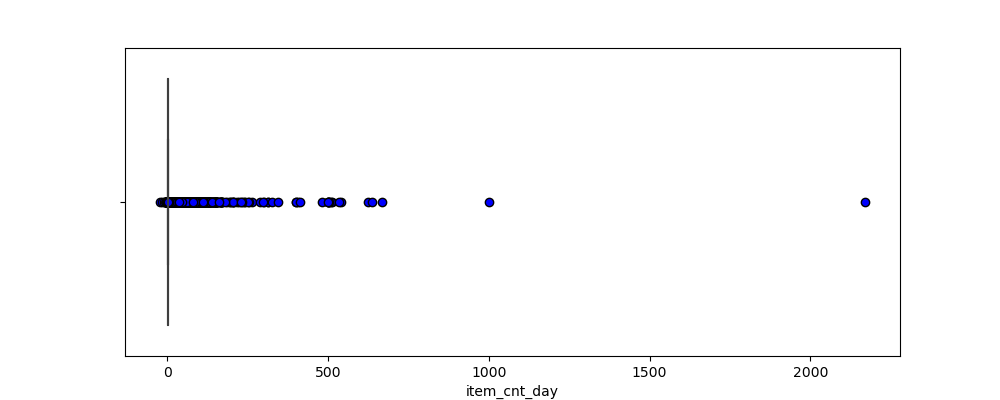

In [226]:
plt.figure(figsize=(10,4))
flierprops = dict(marker='o', markerfacecolor='blue', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=sales_train_df.item_cnt_day, flierprops=flierprops)

<IPython.core.display.Javascript object>


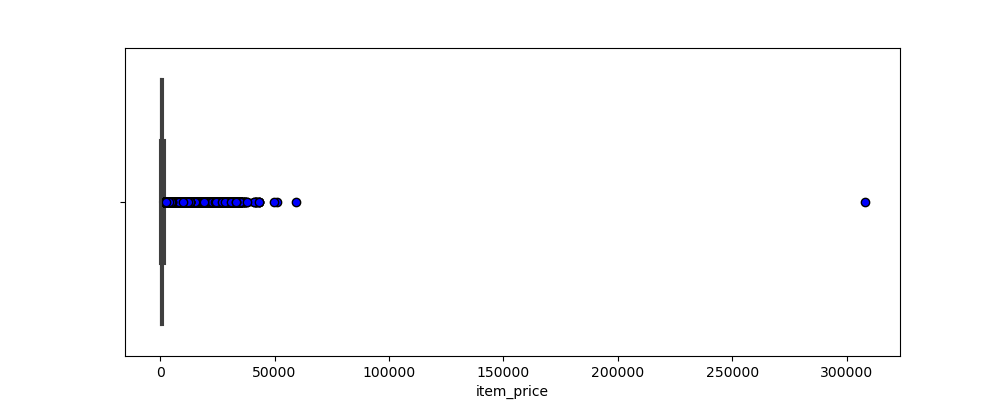

In [227]:
plt.figure(figsize=(10,4))
sns.boxplot(x=sales_train_df.item_price, flierprops=flierprops)

In [228]:
# outlier removal
sales_train_df = sales_train_df[sales_train_df.item_cnt_day < 900]
sales_train_df = sales_train_df[sales_train_df.item_price < 300000]

We should note that there does exist non-positive integers in the item_cnt_day and item_price. This must indicate refunds. Let's keep these values as the model should include the return/refund behaviour. 

In [229]:
print((sales_train_df.item_cnt_day > 0).all())
(sales_train_df.item_price > 0).all()

False


False

#### Categorical Cleanup and Encoding

Shop Data

In [230]:
items_categories_df.nunique()

item_category_name    84
item_category_id      84
dtype: int64

Let's also look at shop names. We should assume that all 60 shops are unique, otherwise there is no point in predicting each shop's individual item count. Let's ensure that every shop sold items at least in the last month in order to prove that each shop is unique and that one didn't close/reopen as another shop. If a shop didn't sell items, we'll keep looking for the last time they did.

In [231]:
last_month_train_df = sales_train_df[sales_train_df.date_block_num == 33]
for shop in last_month_train_df.shop_id.unique():
    if last_month_train_df[last_month_train_df.shop_id==shop].item_cnt_day.sum() <= 0:
        print("shop id {} didn't sell in the last month".format(shop))

Looks good - all shops sold something in the last month.

--For fun, we can compare shop names to check for similarities in the names. The all appear to be unique.

In [232]:
matching_pairs_within_column_name(shops_df, 'shop_name', fuzz.token_set_ratio)

,,match_sort
shop_name,score_sort,
"!Якутск Орджоникидзе, 56 фран",100,"Якутск Орджоникидзе, 56"
"!Якутск ТЦ ""Центральный"" фран",100,"Якутск ТЦ ""Центральный"""
Жуковский ул. Чкалова 39м?,100,Жуковский ул. Чкалова 39м²
"РостовНаДону ТРК ""Мегацентр Горизонт""",100,"РостовНаДону ТРК ""Мегацентр Горизонт"" Островной"
"Москва ТК ""Буденовский"" (пав.А2)",94,"Москва ТК ""Буденовский"" (пав.К7)"
"Н.Новгород ТРЦ ""РИО""",88,"Н.Новгород ТРЦ ""Фантастика"""
"Красноярск ТЦ ""Взлетка Плаза""",84,"Красноярск ТЦ ""Июнь"""
"Москва ТЦ ""Перловский""",83,"Москва ТЦ ""Семеновский"""
"Новосибирск ТРЦ ""Галерея Новосибирск""",81,"Новосибирск ТЦ ""Мега"""


We should also try and split up the shop names - engineering the shop name feature into multiple features. We can notice that shop name has some non-unique values within the name itself (e.g.Якутск , Жуковский , etc.). Let's split on these non-unique names and create new attributes from them. (shop_name_split_1, shop_name_split_2).

In [233]:
shops_df["shop_name_split_1"] = shops_df.shop_name.str.split(" ").map( lambda x: x[0] )
shops_df["shop_name_split_2"] = shops_df.shop_name.str.split(" ").map( lambda x: x[1] )

Let's see if we need to do any clean up of the new feature data, and also categorize them for label encoding (we don't want too many categories labeled for added complexity).

In [234]:
matching_pairs_within_column_name(shops_df, 'shop_name_split_1', fuzz.token_set_ratio)

,,match_sort
shop_name_split_1,score_sort,
!Якутск,100,Якутск
Омск,89,Томск


In [235]:
# adjust Якутск
shops_df.loc[shops_df.shop_name_split_1 == "!Якутск", "shop_name_split_1"] = "Якутск"

In [236]:
# Categorize shop_name_split_1 so that values that only appear once are labeled as other. Helpful for one-hot encoding.
shops_df.shop_name_split_1.value_counts();
cat_thresh = 2
category = []
for cat in shops_df.shop_name_split_1.unique():
    if len(shops_df[shops_df.shop_name_split_1 == cat]) >= cat_thresh:
        category.append(cat)
shops_df.shop_name_split_1 = shops_df.shop_name_split_1.apply( lambda x: x if (x in category) else "other" )

In [237]:
matching_pairs_within_column_name(shops_df, 'shop_name_split_2', fuzz.token_set_ratio)

,,match_sort
shop_name_split_2,score_sort,
МТРЦ,86,ТРЦ
ТК,80,ТРК
ТРЦ,80,ТЦ


In [238]:
shops_df.shop_name_split_2.value_counts();
# Categorize shop_name_split_2 so that values that only appear once are labeled as other. Helpful for numerical label encoding.
shops_df.shop_name_split_2.value_counts();
cat_thresh = 2
category = []
for cat in shops_df.shop_name_split_2.unique():
    if len(shops_df[shops_df.shop_name_split_2 == cat]) >= cat_thresh:
        category.append(cat)
shops_df.shop_name_split_2 = shops_df.shop_name_split_2.apply( lambda x: x if (x in category) else "other" )

Time to label-encode. Data is clean for shop, and we have a decent amount of categories without too much complexity. Let's remove the text data now!

In [239]:
# label encode the shop data
from sklearn.preprocessing import LabelEncoder
shops_df["shop_name_split_1_encode"] = LabelEncoder().fit_transform( shops_df.shop_name_split_1 )
shops_df["shop_name_split_2_encode"] = LabelEncoder().fit_transform( shops_df.shop_name_split_2 )
shops_df = shops_df[["shop_id", "shop_name_split_1_encode", "shop_name_split_2_encode"]]

In [240]:
# sanity check
shops_df.head()

,shop_id,shop_name_split_1_encode,shop_name_split_2_encode
0,0,13,1
1,1,13,5
2,2,0,5
3,3,0,3
4,4,0,5


Item Category Data

Let's perform the same process for the item category data. We'll categorize based on the patterns we see, then we'll check for inconsistencies in the data, and then we'll re-label for label-encoding.

In [241]:
items_categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


Looking at the head of the df, we can tell immediately that 'PC' should probably be labeled after the dash (to be in align with other 'gaming media'. Let's fix all item_cat_names that have PC in them

In [242]:
items_categories_df.loc[items_categories_df.item_category_name.str.contains("PC"),  'item_category_name']

0              PC - Гарнитуры/Наушники
28    Игры PC - Дополнительные издания
29     Игры PC - Коллекционные издания
30       Игры PC - Стандартные издания
31                     Игры PC - Цифра
Name: item_category_name, dtype: object

In [243]:
items_categories_df.loc[items_categories_df.item_category_name == 'PC - Гарнитуры/Наушники', "item_category_name"] = "Гарнитуры/Наушники - PC"
items_categories_df.loc[items_categories_df.item_category_name == 'Игры PC - Дополнительные издания', "item_category_name"] = "Дополнительные издания - Игры PC"
items_categories_df.loc[items_categories_df.item_category_name == 'Игры PC - Коллекционные издания', "item_category_name"] = "Коллекционные издания - Игры PC"
items_categories_df.loc[items_categories_df.item_category_name == 'Игры PC - Стандартные издания', "item_category_name"] = "Стандартные издания - Игры PC"
items_categories_df.loc[items_categories_df.item_category_name == 'Игры PC - Цифра', "item_category_name"] = "Цифра - Игры PC"

We can split on '-' as that appears to be the main delineator in this attribute. Note that not all values have a '-', and this we've filled the consequential NaNs as 'unknown'. 

In [244]:
# Let's split on '-'
items_categories_df["item_cat_split_1"] = items_categories_df.item_category_name.str.split("-").str[0]
items_categories_df["item_cat_split_2"] = items_categories_df.item_category_name.str.split("-").str[1].fillna("unknown")

Finally, we'll categorize and then label encode.

In [245]:
# Categorize item_cat_split_1
cat_thresh = 2
category = []
for cat in items_categories_df.item_cat_split_1.unique():
    if len(items_categories_df[items_categories_df.item_cat_split_1 == cat]) >= cat_thresh:
        category.append(cat)
items_categories_df.item_cat_split_1 = items_categories_df.item_cat_split_1.apply( lambda x: x if (x in category) else "other" )

In [246]:
# Categorize item_cat_split_2
cat_thresh = 2
category = []
for cat in items_categories_df.item_cat_split_2.unique():
    if len(items_categories_df[items_categories_df.item_cat_split_2 == cat]) >= cat_thresh:
        category.append(cat)
items_categories_df.item_cat_split_2 = items_categories_df.item_cat_split_2.apply( lambda x: x if (x in category) else "other" )

In [247]:
# label encode the item cat data
items_categories_df["item_cat_split_1_encode"] = LabelEncoder().fit_transform( items_categories_df.item_cat_split_1 )
items_categories_df["item_cat_split_2_encode"] = LabelEncoder().fit_transform( items_categories_df.item_cat_split_2 )
items_categories_df = items_categories_df[["item_category_id", "item_cat_split_1_encode", "item_cat_split_2_encode"]]

In [248]:
# sanity check
items_categories_df.head()

,item_category_id,item_cat_split_1_encode,item_cat_split_2_encode
0,0,0,10
1,1,1,1
2,2,1,2
3,3,1,3
4,4,1,4


Item Data

We can start by creating a few new columns that contain splits of the item_name. Most of the work done here is removing special characters and isolating non-unique names out of the long item_name string (and placed into new columns).

In [249]:
items_df["name1"], items_df["name2"] = items_df.item_name.str.split("[", 1).str
items_df["name1"], items_df["name3"] = items_df.item_name.str.split("(", 1).str

<ipython-input-249-f181642e20c9>:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items_df["name1"], items_df["name2"] = items_df.item_name.str.split("[", 1).str
<ipython-input-249-f181642e20c9>:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items_df["name1"], items_df["name3"] = items_df.item_name.str.split("(", 1).str


In [250]:
items_df["name2"] = items_df.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items_df["name3"] = items_df.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

In [251]:
items_df = items_df.fillna('0')

In [252]:
items_df["item_name"] = items_df["item_name"].apply(lambda x: name_correction(x))

In [253]:
# drop the last bracket in name2 that was left from the previous str.split
items_df.name2 = items_df.name2.apply( lambda x: x[:-1] if x !="0" else "0")

In [254]:
# The lower the ratio, the 'more categorical' the column
print("name3 ratio: {}".format(items_df.name3.nunique()/items_df.shape[0]))
print("name2 ratio: {}".format(items_df.name2.nunique()/items_df.shape[0]))
print("name1 ratio: {}".format(items_df.name1.nunique()/items_df.shape[0]))

name3 ratio: 0.0751465944970681
name2 ratio: 0.007848443843031122
name1 ratio: 0.929679747406405


Let's now do a deeper preprocessing of the text data in name3, name2. We'll try to identify all the products here and clean it up.

In [255]:
# Let's remove white space before/after
items_df["name2"] = items_df.name2.str.strip()

In [256]:
# the majority of game consoles above is of type xbox (xbox one, xbox 360, xbox360 and x360). 
# we can get most of these by searching over first 8 chars and saving that, then assigning everyting else
# to be just whatever comes first. We don't want to do str.contains() because some rows values have multiple 
# gaming consoles listed.
items_df['type'] = items_df.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0])

In [257]:
items_df['type'].unique()

array(['0', 'pc', 'ps3', 'pс', 'xbox 360', 'цифровая', '', 'mac', 'psp',
       'рs3', 'ps4', 'xbox one', 'x360', 'ps', 'xbox360', 'русская', 'рс',
       'android', 'англ', 'ps2', 'только', 'цифро', '6jv', 'j72', 'hm3',
       's3v', '6dv', '6l6', '5f4', 's4v', 'kg4', '5c5', '5c7', 'kf7',
       'kf6'], dtype=object)

We know that all values that start with '' have 'pc' following, so we'll label those values as 'pc'. We'll also xbox360 values and fix all the pc values, too.

In [258]:
items_df.loc[items_df['type'] == '', 'type'] = 'pc'

In [259]:
# and the rest..
items_df.loc[(items_df.type == "x360") | (items_df.type == "xbox360") | (items_df.type == "xbox 360") ,"type"] = "xbox 360"
items_df.loc[ (items_df.type == 'pc' )| (items_df.type == 'рс') | (items_df.type == 'pс'), "type" ] = "pc"

In [260]:
# Check again
items_df['type'].unique()

array(['0', 'pc', 'ps3', 'xbox 360', 'цифровая', 'mac', 'psp', 'рs3',
       'ps4', 'xbox one', 'ps', 'русская', 'android', 'англ', 'ps2',
       'только', 'цифро', '6jv', 'j72', 'hm3', 's3v', '6dv', '6l6', '5f4',
       's4v', 'kg4', '5c5', '5c7', 'kf7', 'kf6'], dtype=object)

Next, let's just group types that are not as frequent. There are some item types that appear hundreds of times, and many that appear no more than 20 times. This threshold (and the ones before it) can be itereted on to find the best score, but we won't do that here.

In [261]:
group_item_sum = items_df.groupby(["type"]).agg({"item_id": "count"}).reset_index()

In [262]:
drop_cols = []
for cat in group_item_sum.type.unique():
    if group_item_sum.loc[(group_item_sum.type == cat), "item_id"].values[0] <=20:
        drop_cols.append(cat)
items_df.type = items_df.type.apply( lambda x: "other" if (x in drop_cols) else x )
#items_df = items_df.drop(["name2"], axis = 1)

In [263]:
# value counts looks good - the low-volume values were grouped 55 times as 'other'.
items_df.type.value_counts()

0           17661
pc           2664
ps3           610
xbox 360      466
цифровая      223
ps4           174
xbox one      123
psp           115
ps             79
other          55
Name: type, dtype: int64

Encode name3, type and remove the text data left over.

In [264]:
items_df.type = LabelEncoder().fit_transform(items_df.type)
items_df.name3 = LabelEncoder().fit_transform(items_df.name3)
items_df.drop(["item_name", "name1", 'name2'],axis = 1, inplace= True)
items_df.head()

,item_id,item_category_id,name3,type
0,0,40,1331,0
1,1,76,42,2
2,2,40,1011,0
3,3,40,1010,0
4,4,40,1572,0


Now it's time to take all the shop and item data and create one dataframe indexed on increasing month and every shop/item id pair.

In [265]:
# This nifty piece of code will 'productize' uniquely the month number, shop id and item id into one large matrix,
# and then place it vertically in a dataframe! Finally, we'll set the data types more accurately, and do a sort.
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = sales_train_df[sales_train_df.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )
    
matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

7.634771108627319

Let's quickly add a new feature to the train set - revenue (item count * price)

In [266]:
# add revenue to train df
sales_train_df["revenue"] = sales_train_df["item_cnt_day"] * sales_train_df["item_price"]

We'll also need to know the quantity of items sold for each shop on each month for each item id. So,  let's merge the items sold every month to our matrix of month num, shop id and item id product.

In [267]:
ts = time.time()
group = sales_train_df.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)
time.time() - ts

3.9096884727478027

test_df will be our prediction set, and what we'll use for submission. We need to add dat_block_num and have it equal to 34 - this way we can merge to the training set and then split them appropriately for train/predict.

In [268]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [269]:
test_df["date_block_num"] = 34
test_df["date_block_num"] = test_df["date_block_num"].astype(np.int8)
test_df["shop_id"] = test_df.shop_id.astype(np.int8)
test_df["item_id"] = test_df.item_id.astype(np.int16)

In [270]:
# merge!
ts = time.time()

matrix = pd.concat([matrix, test_df.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True ) # not all shop/item_id combos will be in the test set.
time.time() - ts

0.06509065628051758

Finally, let's merge our descriptive data to our matrix. This will include the shop, item and item_cat dataframes.

In [271]:
ts = time.time()
matrix = pd.merge( matrix, shops_df, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items_df, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, items_categories_df, on = ["item_category_id"], how = "left" )
matrix["shop_name_split_1_encode"] = matrix["shop_name_split_1_encode"].astype(np.int8)
matrix["shop_name_split_2_encode"] = matrix["shop_name_split_2_encode"].astype(np.int8)
matrix["item_cat_split_1_encode"] = matrix["item_cat_split_1_encode"].astype(np.int8)
matrix["item_cat_split_2_encode"] = matrix["item_cat_split_2_encode"].astype(np.int8)
matrix["item_type"] = matrix["type"].astype(np.int8)
matrix["item_name3"] = matrix["name3"].astype(np.int16)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
time.time() - ts

3.926121711730957

Let's drop type, name3 as we created new ones on accident to change the name.

In [272]:
matrix.drop(["type", "name3"],axis = 1, inplace= True)

In [273]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_name_split_1_encode,shop_name_split_2_encode,item_category_id,item_cat_split_1_encode,item_cat_split_2_encode,item_type,item_name3
0,0,0,19,0.0,13,1,40,5,10,0,42
1,0,0,27,0.0,13,1,19,3,2,4,42
2,0,0,28,0.0,13,1,30,0,8,2,42
3,0,0,29,0.0,13,1,23,3,6,7,42
4,0,0,32,6.0,13,1,40,5,10,0,42


#### Lag Features

It's time to engineer some lag features for our time-series data set. See here: https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/

We can start with lagging item count month for last three months.

In [274]:
ts = time.time()
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

item_cnt_month


15.032087564468384

Next, we can add the rolling item count mean of the last 1 month. We'll then do the same thing but for every shop/item id combination over the last 3 months.

In [275]:
ts = time.time()
# create the group (because we are doing an agg function)
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns= (['date_avg_item_cnt'])
group.reset_index(inplace=True)

# then let's merge back to the matrix to add the new column
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')

# set the data type
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)

# then lag the feature we just added
matrix = lag_feature(matrix, [1], ['date_avg_item_cnt'])

# drop the newly created feature since it's already been lagged
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_avg_item_cnt


8.795448064804077

In [276]:
ts = time.time()
# create the group (because we are doing an agg function)
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns= (['date_item_avg_item_cnt'])
group.reset_index(inplace=True)

# then let's merge back to the matrix to add the new column
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')

# set the data type
matrix.date_item_avg_item_cnt = matrix["date_item_avg_item_cnt"].astype(np.float16)

# then lag the feature we just added
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])

# drop the newly created feature since it's already been lagged
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


19.978829860687256

In [277]:
ts = time.time()
# create the group (because we are doing an agg function)
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns= (['date_shop_avg_item_cnt'])
group.reset_index(inplace=True)

# then let's merge back to the matrix to add the new column
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id'], how='left')

# set the data type
matrix.date_shop_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)

# then lag the feature we just added
matrix = lag_feature(matrix, [1,2,3], ['date_shop_avg_item_cnt'])

# drop the newly created feature since it's already been lagged
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_avg_item_cnt


20.291975498199463

In [278]:
ts = time.time()
# create the group (because we are doing an agg function)
group = matrix.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns= (['date_shop_item_avg_item_cnt'])
group.reset_index(inplace=True)

# then let's merge back to the matrix to add the new column
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_id'], how='left')

# set the data type
matrix.date_shop_item_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)

# then lag the feature we just added
matrix = lag_feature(matrix, [1,2,3], ['date_shop_item_avg_item_cnt'])

# drop the newly created feature since it's already been lagged
matrix.drop(['date_shop_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_item_avg_item_cnt


28.356128454208374

Let's now lag the other features!

In [279]:
ts = time.time()
# create the group (because we are doing an agg function)
group = matrix.groupby(['date_block_num', 'shop_id', 'item_cat_split_1_encode']).agg({'item_cnt_month': ['mean']})
group.columns= (['date_shop_itemcat1_avg_item_cnt'])
group.reset_index(inplace=True)

# then let's merge back to the matrix to add the new column
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_cat_split_1_encode'], how='left')

# set the data type
matrix.date_shop_itemcat1_avg_item_cnt = matrix["date_shop_itemcat1_avg_item_cnt"].astype(np.float16)

# then lag the feature we just added
matrix = lag_feature(matrix, [1,2,3], ['date_shop_itemcat1_avg_item_cnt'])

# drop the newly created feature since it's already been lagged
matrix.drop(['date_shop_itemcat1_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_itemcat1_avg_item_cnt


22.266098260879517

In [280]:
ts = time.time()
# create the group (because we are doing an agg function)
group = matrix.groupby(['date_block_num', 'shop_id', 'item_cat_split_2_encode']).agg({'item_cnt_month': ['mean']})
group.columns= (['date_shop_itemcat2_avg_item_cnt'])
group.reset_index(inplace=True)

# then let's merge back to the matrix to add the new column
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_cat_split_2_encode'], how='left')

# set the data type
matrix.date_shop_itemcat2_avg_item_cnt = matrix["date_shop_itemcat2_avg_item_cnt"].astype(np.float16)

# then lag the feature we just added
matrix = lag_feature(matrix, [1,2,3], ['date_shop_itemcat2_avg_item_cnt'])

# drop the newly created feature since it's already been lagged
matrix.drop(['date_shop_itemcat2_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_itemcat2_avg_item_cnt


23.08057737350464

In [281]:
ts = time.time()
# create the group (because we are doing an agg function)
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns= (['date_shop_itemcat_avg_item_cnt'])
group.reset_index(inplace=True)

# then let's merge back to the matrix to add the new column
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')

# set the data type
matrix.date_shop_itemcat_avg_item_cnt = matrix["date_shop_itemcat_avg_item_cnt"].astype(np.float16)

# then lag the feature we just added
matrix = lag_feature(matrix, [1,2,3], ['date_shop_itemcat_avg_item_cnt'])

# drop the newly created feature since it's already been lagged
matrix.drop(['date_shop_itemcat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_itemcat_avg_item_cnt


24.049184560775757

In [282]:
ts = time.time()
# create the group (because we are doing an agg function)
group = matrix.groupby(['date_block_num', 'shop_id', 'item_type']).agg({'item_cnt_month': ['mean']})
group.columns= (['date_shop_itemtype_avg_item_cnt'])
group.reset_index(inplace=True)

# then let's merge back to the matrix to add the new column
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_type'], how='left')

# set the data type
matrix.date_shop_itemtype_avg_item_cnt = matrix["date_shop_itemtype_avg_item_cnt"].astype(np.float16)

# then lag the feature we just added
matrix = lag_feature(matrix, [1,2,3], ['date_shop_itemtype_avg_item_cnt'])

# drop the newly created feature since it's already been lagged
matrix.drop(['date_shop_itemtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_itemtype_avg_item_cnt


24.727649211883545

In [283]:
ts = time.time()
# create the group (because we are doing an agg function)
group = matrix.groupby(['date_block_num', 'shop_id', 'item_name3']).agg({'item_cnt_month': ['mean']})
group.columns= (['date_shop_itemname3_avg_item_cnt'])
group.reset_index(inplace=True)

# then let's merge back to the matrix to add the new column
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_name3'], how='left')

# set the data type
matrix.date_shop_itemname3_avg_item_cnt = matrix["date_shop_itemname3_avg_item_cnt"].astype(np.float16)

# then lag the feature we just added
matrix = lag_feature(matrix, [1,2,3], ['date_shop_itemname3_avg_item_cnt'])

# drop the newly created feature since it's already been lagged
matrix.drop(['date_shop_itemname3_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_itemname3_avg_item_cnt


25.99968957901001

Let's also add average price per item as a standalone feature, then we'll also add average item price per month and do lag features that.

In [284]:
group = sales_train_df.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns= (['item_avg_item_price'])
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)

In [285]:
ts = time.time()
# create the group (because we are doing an agg function)
group = sales_train_df.groupby(['date_block_num', 'item_id']).agg({'item_price': ['mean']})
group.columns= (['date_avg_item_price'])
group.reset_index(inplace=True)

# then let's merge back to the matrix to add the new column
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')

# set the data type
matrix.date_avg_item_price = matrix["date_avg_item_price"].astype(np.float16)

# then lag the feature we just added
matrix = lag_feature(matrix, [1,2,3], ['date_avg_item_price'])

# drop the newly created feature since it's already been lagged
matrix.drop(['date_avg_item_price'], axis=1, inplace=True)
time.time() - ts

date_avg_item_price


24.66261100769043

In [286]:
matrix.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.000
shop_id,0.0,0.0,0.0,0.0,0.000
item_id,19.0,27.0,28.0,29.0,32.000
item_cnt_month,0.0,0.0,0.0,0.0,6.000
shop_name_split_1_encode,13.0,13.0,13.0,13.0,13.000
shop_name_split_2_encode,1.0,1.0,1.0,1.0,1.000
item_category_id,40.0,19.0,30.0,23.0,40.000
item_cat_split_1_encode,5.0,3.0,0.0,3.0,5.000
item_cat_split_2_encode,10.0,2.0,8.0,6.0,10.000
item_type,0.0,4.0,2.0,7.0,0.000


### Train and Predictions

In [3]:
import math
import gc
import pickle
from xgboost import XGBRegressor
from sklearn import linear_model, svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve, TimeSeriesSplit, GridSearchCV, cross_val_score, cross_validate
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [288]:
data = matrix.copy()
#del matrix
#gc.collect()

In [289]:
data[data["date_block_num"]==34].shape

(214200, 43)

In [4]:
# if reloading...
data = pd.read_pickle("./data/data.pkl")

In [5]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [6]:
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [297]:
data.to_pickle("./data/data.pkl")

In [7]:
del data
gc.collect();

#### Linear and Lasso Regression

We can train a simple linear regression to fit the data. We can do a simple validation set as being the month right before the test month. This model trains pretty quickly. 

In [292]:
ts = time.time()

model_lr = linear_model.LinearRegression(n_jobs=-1)

model_lr.fit(X_train.fillna(0), Y_train.fillna(0))

# RMSE for Train
preds = model_lr.predict(X_train.fillna(0))
rmse_train = math.sqrt(mean_squared_error(Y_train.fillna(0), preds))
# RMSE for Valid
preds = model_lr.predict(X_valid.fillna(0))
rmse_valid = math.sqrt(mean_squared_error(Y_valid.fillna(0), preds))

print("Train RMSE: {0:.5f}".format(rmse_train))
print("Validation RMSE: {0:.5f}".format(rmse_valid))

time.time() - ts

Train RMSE: 1.05272
Validation RMSE: 1.04890


13.427119731903076

##### Time Series Cross-Validation

Instead of just doing our validation set as the last month in our training set, we should do time series cross-validation. This should help us get a better sense of how well we're tuning our hyperparameters. It's better to get a sample of scores for each tested parameter so we can feel more confident in the actual performance of the model on unseen data.

Time series cross-validation is unlike random k-fold cross-validation since we want to preserve the order of the time series. We chose to do our own method of 'forward chaining' (see below diagrame), where we choose a starting month (date_block_num), train everything before that and including, then test on the following month. We then chain that train set to the next month (the one we just tested on), and repeat till we reach the last month in the data set.

![time series cross validation - forward chaining ex.](./supp/tscv.png)

This procedure is shown on the fast-learning linear regression model. We chose to start the cross validation on month (date_block_num) 28. With a total of 34 months, we'd have a total of 5 train/test splits (or *folds*):

1. Train: 0-28, Valid: 29
2. Train: 0-29, Valid: 30
3. Train: 0-30, Valid: 31
4. Train: 0-31, Valid: 32
5. Train: 0-32, Valid: 33

Month 34 doesn't include any target values (as that's what we're 'testing on' as part of our Kaggle submission), thus the chaining has to stop on a validation of Month 33.

In [8]:
X = pd.concat([X_train, X_valid])
y = pd.concat([Y_train, Y_valid])

In [9]:
train_iters, test_iters = TimeSeriesIters(X, 'date_block_num', 28)

In [367]:
ts = time.time()

model_lr = linear_model.LinearRegression(n_jobs=-1, normalize=True)
scores = cross_val_score(model_lr, X.fillna(0), y.fillna(0), scoring='neg_root_mean_squared_error', cv=zip(train_iters, test_iters),
               n_jobs=-1)

time.time() - ts

36.61097002029419

In [368]:
print("RMSE Validation scores: {}".format(scores*-1))
print("mean: {}".format(scores.mean()*-1))

RMSE Validation scores: [0.94337142 0.83328938 0.90564454 1.00396073 1.04851234]
mean: 0.946955680847168


Lasso Regression

We can try Lasso Regression, which is essentially Linear Regression but with regularization (alpha).By setting alpha=0, however, we obtain the same result as linear regression. If for some reason we see overfitting in our Linear Regression model, we could introduce Lasso Regression and increase alpha to avoid high variance. 

Let's run lasso with alpha=2.

In [10]:
ts = time.time()
model_la= linear_model.Lasso(alpha=2.0, random_state=42)
scores = cross_val_score(model_la, X.fillna(0), y.fillna(0), scoring='neg_root_mean_squared_error', cv=zip(train_iters, test_iters),
               n_jobs=-1)
time.time() - ts

31.638874053955078

In [11]:
print("RMSE Validation scores: {}".format(scores*-1))
print("mean: {}".format(scores.mean()*-1))

RMSE Validation scores: [1.05856836 0.99221921 1.06190693 1.15254235 1.13849509]
mean: 1.0807463884353639


The validation mean RMSE is 12% worse than with just a linear model with alpha=0 (Linear Regression), so we really don't need to try other values of alpha considering the magnitude. Ideally if we did care about overfitting here, we'd plot a learning curve of the data, but more likely we're dealing with a highly biased model (or rather a model that isn't complex enough...)

LR - Submission

In [90]:
# change file_name
file_name = 'lr_submission_mrj.csv'

Y_test = model_lr.predict(X_test.fillna(0)).clip(0, 20)

submission = pd.DataFrame({
    "ID": test_df.index, 
    "item_cnt_month": Y_test
})
submission.to_csv(file_name, index=False)

In [91]:
! kaggle competitions submit -c competitive-data-science-predict-future-sales -f {file_name} -m "lr"

Successfully submitted to Predict Future Sales



  0%|          | 0.00/3.68M [00:00<?, ?B/s]
  2%|2         | 80.0k/3.68M [00:00<00:04, 800kB/s]
  9%|8         | 328k/3.68M [00:00<00:03, 1.00MB/s]
 22%|##2       | 832k/3.68M [00:00<00:02, 1.32MB/s]
 37%|###6      | 1.36M/3.68M [00:00<00:01, 1.71MB/s]
 45%|####5     | 1.66M/3.68M [00:00<00:01, 1.86MB/s]
 53%|#####2    | 1.95M/3.68M [00:00<00:01, 1.22MB/s]
 59%|#####8    | 2.16M/3.68M [00:01<00:01, 1.40MB/s]
 66%|######5   | 2.43M/3.68M [00:01<00:00, 1.62MB/s]
 72%|#######2  | 2.66M/3.68M [00:01<00:01, 967kB/s] 
 80%|#######9  | 2.93M/3.68M [00:01<00:00, 1.21MB/s]
 88%|########7 | 3.23M/3.68M [00:01<00:00, 1.47MB/s]
 94%|#########3| 3.46M/3.68M [00:02<00:00, 1.13MB/s]
100%|##########| 3.68M/3.68M [00:03<00:00, 1.24MB/s]


#### XGBoost

In [247]:
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[16:41:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.18942	validation_1-rmse:1.12212
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.14518	validation_1-rmse:1.08956
[2]	validation_0-rmse:1.10557	validation_1-rmse:1.06372
[3]	validation_0-rmse:1.07592	validation_1-rmse:1.04122
[4]	validation_0-rmse:1.05010	validation_1-rmse:1.02456
[5]	validation_0-rmse:1.02664	validation_1-rmse:1.00996
[6]	validation_0-rmse:1.00645	validation_1-rmse:0.99835
[7]	validation_0-rmse:0.99039	validation_1-rmse:0.98861
[8]	validation_0-rmse:0.97692	validation_1-rmse:0.97992
[9]	validation_0-rmse:0.96442	validation_1-rmse:0.97112
[10]	validatio

1507.8289113044739

Submission

In [250]:
# change file_name
file_name = 'fe_xgb_submission_mrj.csv'

Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test_df.index, 
    "item_cnt_month": Y_test
})
submission.to_csv(file_name, index=False)

Send to kaggle for score

In [251]:
! kaggle competitions submit -c competitive-data-science-predict-future-sales -f {file_name} -m "xgboost with feature engineering"

Successfully submitted to Predict Future Sales



  0%|          | 0.00/3.59M [00:00<?, ?B/s]
  2%|2         | 80.0k/3.59M [00:00<00:04, 805kB/s]
  9%|9         | 336k/3.59M [00:00<00:03, 1.01MB/s]
 25%|##5       | 936k/3.59M [00:00<00:02, 1.34MB/s]
 40%|###9      | 1.43M/3.59M [00:00<00:01, 1.73MB/s]
 49%|####8     | 1.75M/3.59M [00:00<00:01, 1.71MB/s]
 56%|#####6    | 2.02M/3.59M [00:00<00:01, 1.28MB/s]
 62%|######2   | 2.23M/3.59M [00:01<00:01, 1.39MB/s]
 68%|######7   | 2.44M/3.59M [00:01<00:00, 1.54MB/s]
 73%|#######3  | 2.64M/3.59M [00:01<00:01, 879kB/s] 
 83%|########2 | 2.97M/3.59M [00:01<00:00, 1.13MB/s]
 90%|######### | 3.25M/3.59M [00:01<00:00, 1.38MB/s]
 97%|#########6| 3.48M/3.59M [00:02<00:00, 1.05MB/s]
100%|##########| 3.59M/3.59M [00:02<00:00, 1.27MB/s]


<IPython.core.display.Javascript object>


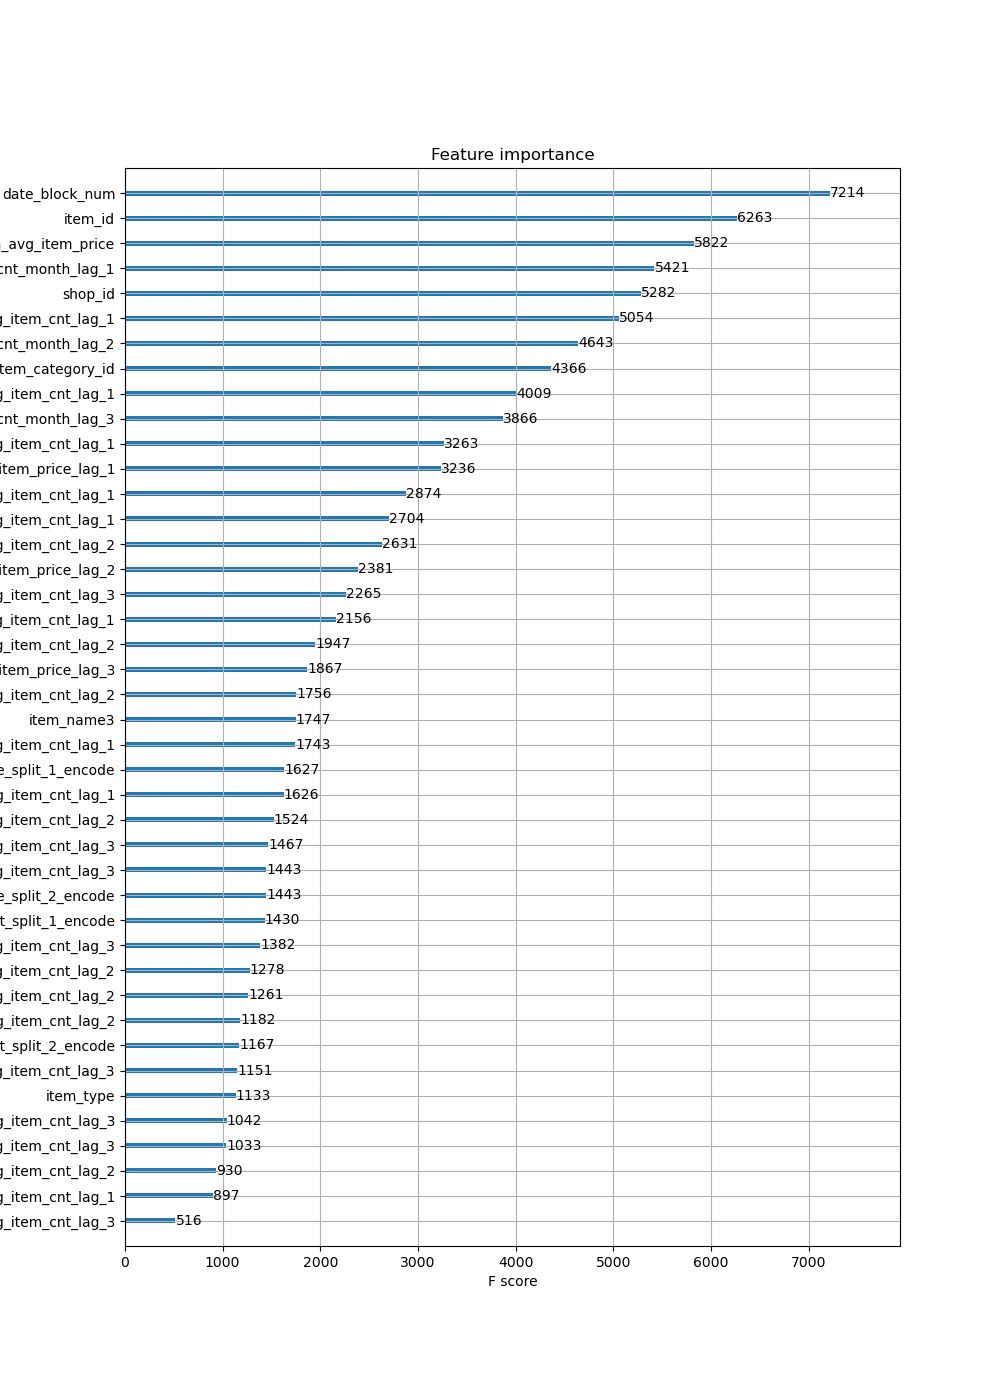

In [252]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

## Improvements

### GridSearchCV

We could also do some grid-searching over the xgboost parameters to fine tune the model. We can do this by executing in essense the following code, which utilizes the GridSearchCV function. This search would be 3 parameter values over a cv time-series split - quite computationally expensive for 10M+ samples and over 40 features! 

In [ ]:
ts = time.time()

# Call GridSearch function
parameters = {'eta':[0.1, 0.2, 0.3]}

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8,
#     tree_method='gpu_hist',
    seed=42)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
reg_xgb_1 = GridSearchCV(model, param_grid=parameters, cv=zip(train_iters, test_iters), verbose=True,
                        scoring='neg_root_mean_squared_error')
reg_xgb_1.fit(X, y)

#reg_xgb_1.best_score_, reg_xgb_1.best_params_

time.time() - ts

### Better feature engineering

We could have introduced more descriptive features to our dataset, namely: 
1. More features relating to price would have been helpful
2. Better domain knowledge of the item and shop names, which would have helped in inferring more about the data and the addition of more features.